In [ ]:
###Glioma Networks DEG Perturbation Analysis

In [8]:
import os
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Create a parent folder for outputs
parent_folder = "Perturbation_Analysis_Results"
os.makedirs(parent_folder, exist_ok=True)

# Load normalized counts CSV
normalized_counts = pd.read_csv("normalized_counts.csv", index_col=0)

# List of DEG files
deg_files = {
    "Glioma": "DESeq2_GliomavsNormal.csv",
    "GBM": "DESeq2_GBMvsNormal.csv",
    "DIPG": "DESeq2_DIPGvsNormal.csv"
}

# Step 1: Filter genes from DEG files
def filter_deg(deg_file):
    """
    Filter the DEG file for genes with padj < 0.05 and |log2FoldChange| >= 2
    """
    df = pd.read_csv(deg_file)
    df_filtered = df[(df['padj'] < 0.05) & (df['log2FoldChange'].abs() >= 2)]
    return df_filtered['Gene'].tolist()  # Return list of filtered gene names

# Step 2: Subset the normalized counts for the filtered genes
def subset_normalized_counts(filtered_genes):
    """
    Subset the normalized counts dataframe to only include filtered genes.
    """
    return normalized_counts.loc[filtered_genes]

# Step 3: Generate adjacency matrix using Spearman correlation
def generate_adjacency_matrix(filtered_counts):
    """
    Generate the adjacency matrix using Spearman correlation for filtered genes.
    """
    corr_matrix, _ = spearmanr(filtered_counts, axis=1)
    return pd.DataFrame(corr_matrix, index=filtered_counts.index, columns=filtered_counts.index)

# Generate and save adjacency matrices
adjacency_files = {}

for tissue_type, deg_file in deg_files.items():
    # Filter genes based on DEG file
    filtered_genes = filter_deg(deg_file)
    
    # Subset normalized counts
    filtered_counts = subset_normalized_counts(filtered_genes)
    
    # Generate adjacency matrix
    adj_matrix = generate_adjacency_matrix(filtered_counts)
    
    # Save adjacency matrix
    adjacency_file = os.path.join(parent_folder, f"{tissue_type}_adjacency_matrix.csv")
    adj_matrix.to_csv(adjacency_file)
    adjacency_files[tissue_type] = adjacency_file

print("Adjacency matrices generated and saved.")


Adjacency matrices generated and saved.


In [9]:
from pybdm import BDM, PerturbationExperiment
import matplotlib.pyplot as plt

# Folder to save perturbation analysis results
output_folder = "Perturbation_Analysis_Results"
os.makedirs(output_folder, exist_ok=True)

# Function for BDM perturbation analysis
def bdm_perturbation_analysis(adj_matrix):
    """
    Perform BDM perturbation analysis on an adjacency matrix.
    """
    bdm = BDM(ndim=2)
    binary_matrix = (adj_matrix > 0).astype(int).values  # Binarize adjacency matrix
    perturbation = PerturbationExperiment(bdm, binary_matrix, metric='bdm')
    delta_bdm = perturbation.run()
    reshaped_delta_bdm = np.reshape(delta_bdm, adj_matrix.shape)
    return pd.DataFrame(reshaped_delta_bdm, index=adj_matrix.index, columns=adj_matrix.columns)

# Function to save top 10 perturbation genes
def save_top_perturbation_genes(perturbation_results, tissue_type):
    """
    Save the top 10 genes with the highest perturbation values.
    """
    perturbation_scores = perturbation_results.abs().sum(axis=1)
    top_genes = perturbation_scores.nlargest(10)
    top_genes.to_csv(os.path.join(output_folder, f"Top_10_Perturbation_Genes_{tissue_type}.csv"), header=["Perturbation_Score"])

# Function to plot perturbation scores
def plot_perturbation_scores(perturbation_results, tissue_type):
    """
    Plot the total perturbation scores for the network.
    """
    perturbation_scores = perturbation_results.abs().sum(axis=1)
    plt.figure(figsize=(10, 6))
    perturbation_scores.sort_values(ascending=False).head(10).plot(kind="bar")
    plt.title(f"Top 10 Perturbation Scores - {tissue_type}")
    plt.ylabel("Perturbation Score")
    plt.xlabel("Gene")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"Top_10_Perturbation_Scores_{tissue_type}.png"))
    plt.close()

# Perform perturbation analysis
for tissue_type, adjacency_file in adjacency_files.items():
    # Load adjacency matrix
    adj_matrix = pd.read_csv(adjacency_file, index_col=0)
    
    # Perform BDM perturbation analysis
    perturbation_results = bdm_perturbation_analysis(adj_matrix)
    
    # Save perturbation results
    perturbation_results.to_csv(os.path.join(output_folder, f"{tissue_type}_Perturbation_Results.csv"))
    
    # Save top 10 genes
    save_top_perturbation_genes(perturbation_results, tissue_type)
    
    # Plot top perturbation scores
    plot_perturbation_scores(perturbation_results, tissue_type)

print(f"Perturbation analysis completed. Results saved in the '{output_folder}' folder.")


Perturbation analysis completed. Results saved in the 'Perturbation_Analysis_Results' folder.


In [ ]:
###Network Centrality Measures(LZW and BDM)

In [12]:
###PID Metric: Inference

In [15]:
import os
import pandas as pd
import numpy as np

# Placeholder for the PID function (implement or import the PID calculation function)
# from pid_library import calculate_pid

# Create a new parent folder for outputs
parent_folder = "PID_Analysis_Results"
os.makedirs(parent_folder, exist_ok=True)

# Load normalized counts CSV
normalized_counts = pd.read_csv("normalized_counts.csv", index_col=0)

# List of DEG files
deg_files = {
    "Glioma": "DESeq2_GliomavsNormal.csv",
    "GBM": "DESeq2_GBMvsNormal.csv",
    "DIPG": "DESeq2_DIPGvsNormal.csv"
}

# Step 1: Filter genes from DEG files
def filter_deg(deg_file):
    """
    Filter the DEG file for genes with padj < 0.05 and |log2FoldChange| >= 2
    """
    df = pd.read_csv(deg_file)
    df_filtered = df[(df['padj'] < 0.05) & (df['log2FoldChange'].abs() >= 2)]
    return df_filtered['Gene'].tolist()  # Return list of filtered gene names

# Step 2: Subset the normalized counts for the filtered genes
def subset_normalized_counts(filtered_genes):
    """
    Subset the normalized counts dataframe to only include filtered genes.
    """
    return normalized_counts.loc[filtered_genes]

# Step 3: Generate adjacency matrix using PID
def generate_adjacency_matrix_pid(filtered_counts):
    """
    Generate the adjacency matrix using PID for filtered genes.
    """
    gene_list = filtered_counts.index.tolist()
    n_genes = len(gene_list)
    pid_matrix = np.zeros((n_genes, n_genes))
    
    # Calculate PID pairwise (placeholder for actual PID computation)
    for i in range(n_genes):
        for j in range(n_genes):
            if i != j:
                # Replace with actual PID calculation between gene_i and gene_j
                pid_matrix[i, j] = np.random.random()  # Placeholder: random values
    
    return pd.DataFrame(pid_matrix, index=gene_list, columns=gene_list)

# Generate and save adjacency matrices
adjacency_files = {}

for tissue_type, deg_file in deg_files.items():
    # Create a folder for each tissue type
    tissue_folder = os.path.join(parent_folder, tissue_type)
    os.makedirs(tissue_folder, exist_ok=True)
    
    # Filter genes based on DEG file
    filtered_genes = filter_deg(deg_file)
    
    # Subset normalized counts
    filtered_counts = subset_normalized_counts(filtered_genes)
    
    # Generate adjacency matrix using PID
    adj_matrix = generate_adjacency_matrix_pid(filtered_counts)
    
    # Save adjacency matrix with unique file names
    adjacency_file = os.path.join(tissue_folder, f"{tissue_type}_PID_adjacency_matrix.csv")
    adj_matrix.to_csv(adjacency_file)
    adjacency_files[tissue_type] = adjacency_file

print("PID-based adjacency matrices generated and saved in:", parent_folder)


PID-based adjacency matrices generated and saved in: PID_Analysis_Results


KeyError: 0

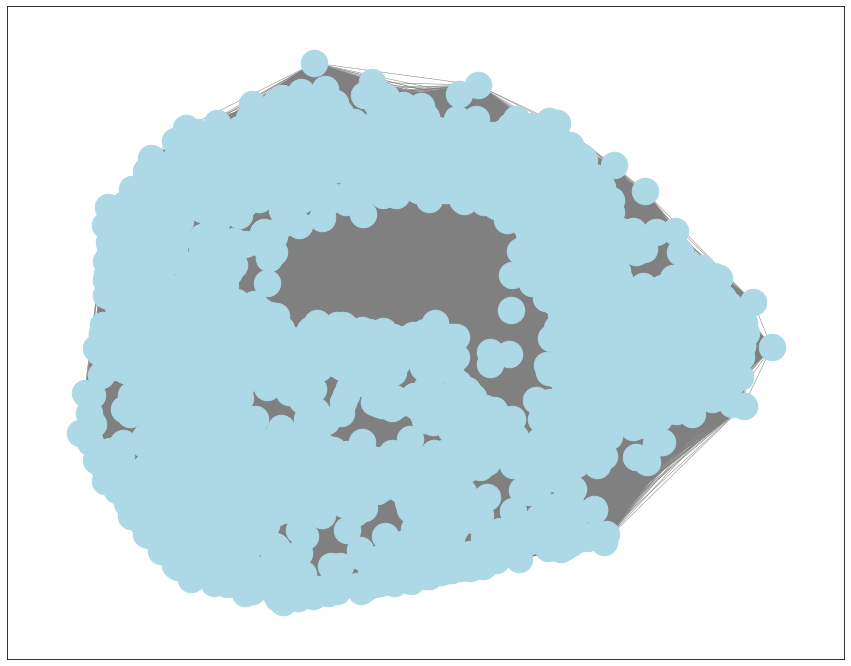

In [16]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pybdm import BDM
import zlib

# Define input and output folders
adjacency_folder = "PID_Analysis_Results"
output_folder = os.path.join(adjacency_folder, "Processed_Network_Analysis_PID")
os.makedirs(output_folder, exist_ok=True)

# List of adjacency matrix files
adjacency_files = {
    "Glioma": os.path.join(adjacency_folder, "Glioma", "Glioma_PID_adjacency_matrix.csv"),
    "GBM": os.path.join(adjacency_folder, "GBM", "GBM_PID_adjacency_matrix.csv"),
    "DIPG": os.path.join(adjacency_folder, "DIPG", "DIPG_PID_adjacency_matrix.csv")
}

# Step 4: Compute BDM, entropy, and LZW compression
def compute_bdm_and_entropy(matrix):
    """
    Compute BDM and entropy for a binary matrix.
    """
    bdm = BDM(ndim=2)
    binary_matrix = (matrix > 0).astype(int).values  # Convert to binary
    bdm_value = bdm.bdm(binary_matrix)
    entropy_value = bdm.ent(binary_matrix)
    return bdm_value, entropy_value

def lzw_compress(matrix):
    """
    Compute the LZW compression size of the matrix.
    """
    data = matrix.tobytes()
    compressed_data = zlib.compress(data)
    return len(compressed_data)

# Step 5: Centrality measures and visualization
def compute_centrality_measures(matrix, gene_names):
    """
    Compute centrality measures for a network.
    """
    G = nx.from_numpy_array(matrix)
    centralities = {
        "Closeness": nx.closeness_centrality(G),
        "Betweenness": nx.betweenness_centrality(G),
        "Eigenvector": nx.eigenvector_centrality(G),
        "Hub": nx.hits(G, max_iter=1000)[0],  # HITS algorithm gives hub scores
    }
    centrality_results = {k: {gene_names[i]: v for i, v in v_dict.items()} for k, v_dict in centralities.items()}
    return centrality_results

def plot_network(adj_matrix, gene_names, title, output_folder):
    """
    Plot the network from an adjacency matrix.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix.to_numpy())
    
    # Assign gene names to nodes as attributes
    mapping = {i: gene_names[i] for i in range(len(gene_names))}
    G = nx.relabel_nodes(G, mapping)
    
    # Generate positions for nodes
    pos = nx.spring_layout(G, seed=42)
    
    # Plot the graph
    plt.figure(figsize=(15, 12))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    # Add a title and save the figure
    plt.title(title)
    plt.savefig(os.path.join(output_folder, f"{title.replace(' ', '_')}.png"))
    plt.close()

# Process each adjacency matrix
for tissue_type, adjacency_file in adjacency_files.items():
    # Load adjacency matrix
    adj_matrix = pd.read_csv(adjacency_file, index_col=0)
    gene_names = adj_matrix.index.tolist()  # List of gene names
    
    # Compute BDM, entropy, and LZW compression
    bdm_value, entropy_value = compute_bdm_and_entropy(adj_matrix)
    lzw_value = lzw_compress(adj_matrix.to_numpy())
    
    # Create tissue-specific output folder
    tissue_output_folder = os.path.join(output_folder, tissue_type)
    os.makedirs(tissue_output_folder, exist_ok=True)
    
    # Save BDM and LZW results
    with open(os.path.join(tissue_output_folder, f"{tissue_type}_metrics.txt"), "w") as f:
        f.write(f"BDM Value: {bdm_value}\n")
        f.write(f"Entropy Value: {entropy_value}\n")
        f.write(f"LZW Compressed Size: {lzw_value}\n")
    
    # Compute centrality measures
    centrality_results = compute_centrality_measures(adj_matrix.to_numpy(), gene_names)
    
    # Save top centrality measures
    top_genes_df = pd.DataFrame()
    for centrality_type, centrality_dict in centrality_results.items():
        sorted_genes = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:20]
        top_genes_df[centrality_type] = [gene for gene, _ in sorted_genes]
    
    top_genes_df.to_csv(os.path.join(tissue_output_folder, f"top_{tissue_type}_centralities.csv"), index=False)
    
    # Plot the network
    plot_network(adj_matrix, gene_names, f"{tissue_type} Network", tissue_output_folder)

print(f"Network analysis completed. Results saved in '{output_folder}'.")


In [17]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from pybdm import BDM
import zlib

# Define input and output folders
adjacency_folder = "PID_Analysis_Results"
output_folder = os.path.join(adjacency_folder, "Processed_Network_Analysis_PID")
os.makedirs(output_folder, exist_ok=True)

# List of adjacency matrix files for GBM and DIPG only
adjacency_files = {
    "GBM": os.path.join(adjacency_folder, "GBM", "GBM_PID_adjacency_matrix.csv"),
    "DIPG": os.path.join(adjacency_folder, "DIPG", "DIPG_PID_adjacency_matrix.csv")
}

# Step 4: Compute BDM, entropy, and LZW compression
def compute_bdm_and_entropy(matrix):
    """
    Compute BDM and entropy for a binary matrix.
    """
    bdm = BDM(ndim=2)
    binary_matrix = (matrix > 0).astype(int).values  # Convert to binary
    bdm_value = bdm.bdm(binary_matrix)
    entropy_value = bdm.ent(binary_matrix)
    return bdm_value, entropy_value

def lzw_compress(matrix):
    """
    Compute the LZW compression size of the matrix.
    """
    data = matrix.tobytes()
    compressed_data = zlib.compress(data)
    return len(compressed_data)

# Step 5: Centrality measures computation
def compute_centrality_measures(matrix, gene_names):
    """
    Compute centrality measures for a network.
    """
    G = nx.from_numpy_array(matrix)
    centralities = {
        "Closeness": nx.closeness_centrality(G),
        "Betweenness": nx.betweenness_centrality(G),
        "Eigenvector": nx.eigenvector_centrality(G),
        "Hub": nx.hits(G, max_iter=1000)[0],  # HITS algorithm gives hub scores
    }
    centrality_results = {k: {gene_names[i]: v for i, v in v_dict.items()} for k, v_dict in centralities.items()}
    return centrality_results

# Process each adjacency matrix
for tissue_type, adjacency_file in adjacency_files.items():
    # Load adjacency matrix
    adj_matrix = pd.read_csv(adjacency_file, index_col=0)
    gene_names = adj_matrix.index.tolist()  # List of gene names
    
    # Compute BDM, entropy, and LZW compression
    bdm_value, entropy_value = compute_bdm_and_entropy(adj_matrix)
    lzw_value = lzw_compress(adj_matrix.to_numpy())
    
    # Create tissue-specific output folder
    tissue_output_folder = os.path.join(output_folder, tissue_type)
    os.makedirs(tissue_output_folder, exist_ok=True)
    
    # Save BDM and LZW results
    with open(os.path.join(tissue_output_folder, f"{tissue_type}_metrics.txt"), "w") as f:
        f.write(f"BDM Value: {bdm_value}\n")
        f.write(f"Entropy Value: {entropy_value}\n")
        f.write(f"LZW Compressed Size: {lzw_value}\n")
    
    # Compute centrality measures
    centrality_results = compute_centrality_measures(adj_matrix.to_numpy(), gene_names)
    
    # Save top centrality measures
    top_genes_df = pd.DataFrame()
    for centrality_type, centrality_dict in centrality_results.items():
        sorted_genes = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:20]
        top_genes_df[centrality_type] = [gene for gene, _ in sorted_genes]
    
    top_genes_df.to_csv(os.path.join(tissue_output_folder, f"top_{tissue_type}_centralities.csv"), index=False)

print(f"Network analysis for GBM and DIPG completed. Results saved in '{output_folder}'.")


Network analysis for GBM and DIPG completed. Results saved in 'PID_Analysis_Results\Processed_Network_Analysis_PID'.


In [ ]:
###Perturbation Analysis

In [18]:
import os
import pandas as pd
import numpy as np
from pybdm import BDM, PerturbationExperiment
import matplotlib.pyplot as plt

# Define the folder containing adjacency matrices
adjacency_folder = "PID_Analysis_Results"

# List of adjacency matrix files
adjacency_files = {
    "Glioma": os.path.join(adjacency_folder, "Glioma", "Glioma_PID_adjacency_matrix.csv"),
    "GBM": os.path.join(adjacency_folder, "GBM", "GBM_PID_adjacency_matrix.csv"),
    "DIPG": os.path.join(adjacency_folder, "DIPG", "DIPG_PID_adjacency_matrix.csv")
}

# Folder to save perturbation analysis results
output_folder = "Perturbation_Analysis_Results"
os.makedirs(output_folder, exist_ok=True)

# Create subfolders for gene-gene and single-gene node perturbations
gene_gene_folder = os.path.join(output_folder, "Gene_Gene_Perturbations")
single_node_folder = os.path.join(output_folder, "Single_Node_Perturbations")
os.makedirs(gene_gene_folder, exist_ok=True)
os.makedirs(single_node_folder, exist_ok=True)

# Function for BDM perturbation analysis
def bdm_perturbation_analysis(adj_matrix):
    """
    Perform BDM perturbation analysis on an adjacency matrix.
    """
    bdm = BDM(ndim=2)
    binary_matrix = (adj_matrix > 0).astype(int).values  # Binarize adjacency matrix
    perturbation = PerturbationExperiment(bdm, binary_matrix, metric='bdm')
    delta_bdm = perturbation.run()
    reshaped_delta_bdm = np.reshape(delta_bdm, adj_matrix.shape)
    return pd.DataFrame(reshaped_delta_bdm, index=adj_matrix.index, columns=adj_matrix.columns)

# Function to save top 30 perturbation values (gene-gene)
def save_top_perturbation_gene_gene(perturbation_results, tissue_type):
    """
    Save the top 30 gene-gene perturbation pairs with the highest absolute values.
    """
    perturbation_scores = perturbation_results.abs().unstack().sort_values(ascending=False)
    top_perturbations = perturbation_scores.head(30)
    top_perturbations.to_csv(os.path.join(gene_gene_folder, f"Top_30_Perturbations_Gene_Gene_{tissue_type}.csv"), header=["Perturbation_Score"])

# Function to save top 30 single-node perturbations
def save_top_perturbation_single_node(perturbation_results, tissue_type):
    """
    Save the top 30 genes with the highest total absolute perturbation values caused by a single node.
    """
    perturbation_scores = perturbation_results.abs().sum(axis=1)
    top_perturbations = perturbation_scores.nlargest(30)
    top_perturbations.to_csv(os.path.join(single_node_folder, f"Top_30_Single_Node_Perturbations_{tissue_type}.csv"), header=["Perturbation_Score"])

# Perform perturbation analysis
for tissue_type, adjacency_file in adjacency_files.items():
    # Load adjacency matrix
    adj_matrix = pd.read_csv(adjacency_file, index_col=0)
    
    # Perform BDM perturbation analysis
    perturbation_results = bdm_perturbation_analysis(adj_matrix)
    
    # Save full perturbation results
    perturbation_results.to_csv(os.path.join(output_folder, f"{tissue_type}_Full_Perturbation_Results.csv"))
    
    # Save top 30 gene-gene perturbations
    save_top_perturbation_gene_gene(perturbation_results, tissue_type)
    
    # Save top 30 single-node perturbations
    save_top_perturbation_single_node(perturbation_results, tissue_type)

print(f"Perturbation analysis completed. Results saved in the '{output_folder}' folder.")


Perturbation analysis completed. Results saved in the 'Perturbation_Analysis_Results' folder.


In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_cdf(file_path, cdf_plot_path, title, color):
    """
    Plot and save a high-quality large CDF plot for a dataset.
    """
    # Load the matrix
    data = pd.read_csv(file_path, index_col=0)
    
    # Flatten the matrix and extract absolute values
    flattened = data.stack().reset_index()
    flattened.columns = ["Gene 1", "Gene 2", "Value"]
    
    # Convert "Value" to numeric, coercing errors to NaN, and drop rows with NaN
    flattened["Value"] = pd.to_numeric(flattened["Value"], errors="coerce")
    flattened.dropna(subset=["Value"], inplace=True)
    
    flattened["Absolute Value"] = flattened["Value"].abs()
    
    # Generate CDF plot
    sorted_scores = flattened["Absolute Value"].sort_values()
    cumulative = sorted_scores.rank(method='average', pct=True) * 100

    plt.figure(figsize=(12, 10))
    plt.plot(sorted_scores, cumulative, color=color, linewidth=3.5)
    plt.title(f"{title}", fontsize=24, fontweight='bold')
    plt.xlabel("Perturbation Score", fontsize=20, fontweight='bold')
    plt.ylabel("Cumulative % of Gene Pairs", fontsize=20, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(cdf_plot_path, dpi=300)  # Save with high quality
    plt.close()

# Folder paths for results and plots
output_folder = "Perturbation_Analysis_Results"
cdf_folder = os.path.join(output_folder, "CDF_Plots")
os.makedirs(cdf_folder, exist_ok=True)

# File paths for Glioma results
glioma_gene_gene_file = os.path.join(output_folder, "Gene_Gene_Perturbations", "Top_30_Perturbations_Gene_Gene_Glioma.csv")
glioma_single_node_file = os.path.join(output_folder, "Single_Node_Perturbations", "Top_30_Single_Node_Perturbations_Glioma.csv")

# Output CDF plot paths
glioma_gene_gene_cdf_plot = os.path.join(cdf_folder, "High_Quality_CDF_Gene_Gene_Glioma.png")
glioma_single_node_cdf_plot = os.path.join(cdf_folder, "High_Quality_CDF_Single_Node_Glioma.png")

# Generate CDF plots
plot_cdf(glioma_gene_gene_file, glioma_gene_gene_cdf_plot, "CDF of Gene-Gene Perturbations - Glioma", "blue")
plot_cdf(glioma_single_node_file, glioma_single_node_cdf_plot, "CDF of Single-Node Perturbations - Glioma", "red")

print(f"CDF plots saved in the folder: {cdf_folder}")


CDF plots saved in the folder: Perturbation_Analysis_Results\CDF_Plots
